# Planetary Boundary Layer Height Uncertainty by Gaussian Process Monte Carlo Method

In [6]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tqdm
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
import gruanpy as gp
INPUT_VARIABLES = ['time', 'alt', 'temp', 'rh', 'press', 'wspeed', 'wdir']
VARIABLES = [v for var in INPUT_VARIABLES for v in (var, var + '_uc') if var != 'time']+ ['time']

In [26]:
# data
folder = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "gdp", "products_RS41-GDP-1_LIN_2017"))
def read_folder(path=folder):
    for fname in sorted(os.listdir(path)):
        fpath = os.path.join(path, fname)
        if not os.path.isfile(fpath):
            continue
        yield gp.read(fpath)
gdps=read_folder(folder)
gdp=next(gdps)
data=gdp.data[0:1000]
data = data[VARIABLES].dropna().reset_index(drop=True)
where = gdp.global_attrs[gdp.global_attrs['Attribute'] == 'g.Site.Name']['Value'].values[0] # location
when = gdp.global_attrs[gdp.global_attrs['Attribute'] == 'g.Measurement.StartTime']['Value'].values[0] # time


In [27]:
# apply pblh methods
data = gp.parcel_method(data) # calculate PBLH using parcel method
data = gp.potential_temperature_gradient(data, virtual=True) # calculate potential temperature gradient
data = gp.RH_gradient(data) # calculate RH gradient
data = gp.specific_humidity_gradient(data) # calculate specific humidity gradient
data = gp.bulk_richardson_number_method(data) # calculate PBLH using bulk Richardson number method
pblh_pm = data['alt'][data['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in data and any(data['pblh_pm'] == 1) else None
pblh_theta = data['alt'][data['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in data and any(data['pblh_theta'] == 1) else None 
pblh_rh = data['alt'][data['pblh_rh'] == 1].iloc[0] if 'pblh_rh' in data and any(data['pblh_rh'] == 1) else None
pblh_q = data['alt'][data['pblh_q'] == 1].iloc[0] if 'pblh_q' in data and any(data['pblh_q'] == 1) else None
pblh_Ri = data['alt'][data['pblh_Ri'] == 1].iloc[0] if 'pblh_Ri' in data and any(data['pblh_Ri'] == 1) else None


In [36]:
# kernel function
def exponential_kernel(x1, x2, length_scale=100, variance=1.0):
    """Exponential kernel function."""
    dists = np.abs(x1[:, None] - x2[None, :])
    return variance * np.exp(-dists.astype(float) / length_scale)

def gp_regression(X1, y1, var1, X2, kernel_func, length_scale):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    observation variances var1, and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1, length_scale=length_scale) + np.diag(var1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, length_scale=length_scale)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, length_scale=length_scale)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

def posterior_samples(X1, y1, var1, X2, kernel_func, size=1, normalize=False, length_scale=100):
    """Draw samples from the posterior Gaussian process."""
    if normalize:
        y1_mean = np.mean(y1)
        y1_std = np.std(y1)
        y1 = (y1 - y1_mean) / y1_std
        var1 = var1 / (y1_std ** 2)
    μ2, Σ2 = gp_regression(X1, y1, var1, X2, kernel_func, length_scale)
    μ2 = μ2 * y1_std + y1_mean if normalize else μ2
    Σ2 = Σ2 * (y1_std ** 2) if normalize else Σ2
    return np.random.multivariate_normal(μ2, Σ2, size=size)

In [43]:
# Monte Carlo uncertainty estimation
M=2
noisy_profiles = []
pblh_samples = {'pm': [], 'theta': [], 'rh': [], 'q': [], 'Ri': []}
for _ in tqdm.tqdm(range(M)):
    noisy_data = data[[col for col in VARIABLES if col in data.columns]].copy(deep=True)
    for var in INPUT_VARIABLES[1:]:  # skip 'time'
        noisy_data[var] = posterior_samples(
            X1=noisy_data['time'].values,
            y1=noisy_data[var].values,
            var1=(noisy_data[var + '_uc'].values*0.5)**2,
            X2=noisy_data['time'].values,
            kernel_func=exponential_kernel,
            size=1,
            normalize=True,
            length_scale=100
        )[0]
    noisy_data = noisy_data.sort_values('alt').reset_index(drop=True)
    # Apply PBLH methods to noisy profile
    noisy_data = gp.parcel_method(noisy_data) # calculate PBLH using parcel method
    noisy_data = gp.potential_temperature_gradient(noisy_data, virtual=True) # calculate potential
    noisy_data = gp.RH_gradient(noisy_data) # calculate RH gradient
    noisy_data = gp.specific_humidity_gradient(noisy_data) # calculate specific humidity gradient
    noisy_data = gp.bulk_richardson_number_method(noisy_data) # calculate P
    noisy_profiles.append(noisy_data)
    pblh_samples['pm'].append(noisy_data['alt'][noisy_data['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in noisy_data and any(noisy_data['pblh_pm'] == 1) else None)
    pblh_samples['theta'].append(noisy_data['alt'][noisy_data['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in noisy_data and any(noisy_data['pblh_theta'] == 1) else None)
    pblh_samples['rh'].append(noisy_data['alt'][noisy_data['pblh_rh'] == 1].iloc[0] if 'pblh_rh' in noisy_data and any(noisy_data['pblh_rh'] == 1) else None)
    pblh_samples['q'].append(noisy_data['alt'][noisy_data['pblh_q'] == 1].iloc[0] if 'pblh_q' in noisy_data and any(noisy_data['pblh_q'] == 1) else None)
    pblh_samples['Ri'].append(noisy_data['alt'][noisy_data['pblh_Ri'] == 1].iloc[0] if 'pblh_Ri' in noisy_data and any(noisy_data['pblh_Ri'] == 1) else None)
# Calculate mean and std of PBLH estimates
pblh_estimates = {}
for method, samples in pblh_samples.items():
    pblh_estimates[method] = {
        'mean': np.mean(samples),
        'std': np.std(samples)
    }
# Results
print("PBLH Estimates (mean ± std):")
for method, stats in pblh_estimates.items():
    print(f"  {method}: {stats['mean']:.2f} ± {stats['std']:.2f} m")

100%|██████████| 2/2 [00:07<00:00,  3.98s/it]

PBLH Estimates (mean ± std):
  pm: 125.69 ± 13.23 m
  theta: 3094.83 ± 509.60 m
  rh: 3145.73 ± 421.10 m
  q: 2303.30 ± 1263.53 m
  Ri: 383.99 ± 0.03 m


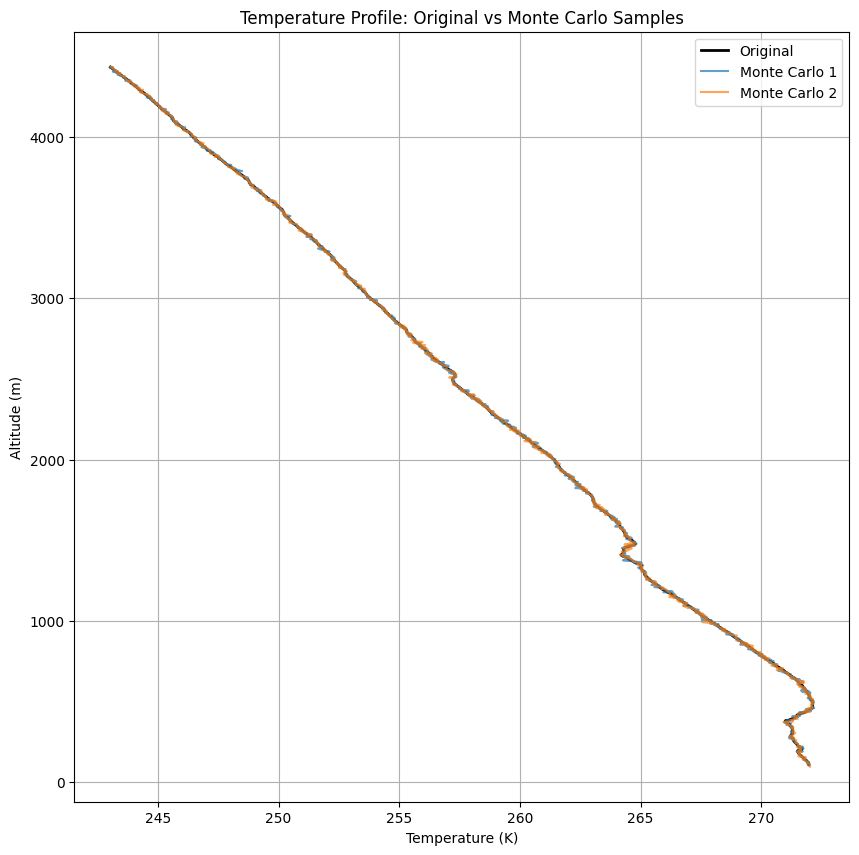

In [44]:
plt.figure(figsize=(10, 10))
plt.plot(data['temp'], data['alt'], label='Original', color='black', linewidth=2)
for i, noisy in enumerate(noisy_profiles):
    plt.plot(noisy['temp'], noisy['alt'], label=f'Monte Carlo {i+1}', alpha=0.7)
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (m)')
plt.title('Temperature Profile: Original vs Monte Carlo Samples')
plt.legend()
plt.grid(True)
plt.show()